In [1]:
import yfinance as yf
import datetime  # For datetime objects
import backtrader as bt

In [3]:
data = bt.feeds.PandasData(dataname=yf.download('SPY', '2000-01-01', '2022-09-21'))

[*********************100%***********************]  1 of 1 completed


Starting Portfolio Value: 10000.00
2001-10-15, BUY CREATE, 109.30
2001-10-16, Order Canceled/Margin/Rejected
2001-10-16, BUY CREATE, 109.99
2001-10-17, BUY EXECUTED, Price: 107.65, Cost: 9688.50, Comm 9.69
2002-04-09, SELL CREATE, 112.14
2002-04-10, SELL EXECUTED, Price: 113.41, Cost: 9688.50, Comm 10.21
2002-10-29, BUY CREATE, 88.57
2002-10-30, Order Canceled/Margin/Rejected
2002-10-30, BUY CREATE, 89.43
2002-10-31, BUY EXECUTED, Price: 88.52, Cost: 10356.84, Comm 10.36
2003-02-11, SELL CREATE, 83.43
2003-02-12, SELL EXECUTED, Price: 82.10, Cost: 10356.84, Comm 9.61
2004-06-17, BUY CREATE, 113.83
2004-06-18, BUY EXECUTED, Price: 113.63, Cost: 9658.55, Comm 9.66
2013-06-11, SELL CREATE, 163.10
2013-06-12, SELL EXECUTED, Price: 161.75, Cost: 9658.55, Comm 13.75
2013-09-19, BUY CREATE, 172.76
2013-09-20, BUY EXECUTED, Price: 170.72, Cost: 13486.88, Comm 13.49
2014-09-25, SELL CREATE, 196.34
2014-09-26, SELL EXECUTED, Price: 197.90, Cost: 13486.88, Comm 15.63
2014-11-05, BUY CREATE, 202.3

<IPython.core.display.Javascript object>


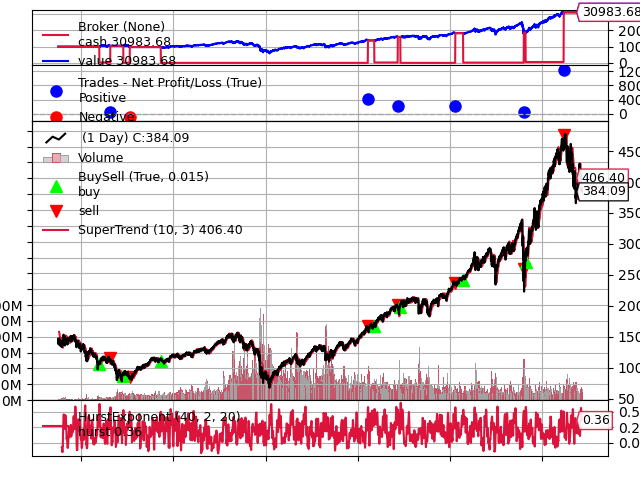

Final Portfolio Value: 30983.68


In [4]:
from pickle import FALSE
import backtrader as bt

#from Data.AmeriTradeHistoryDataService import AmeriTradeHistoryDataService
#from Strategies import RSIStrategy as rsi
#from Data import BacktestResultDB as db
import backtrader.analyzers as btanalyzers
import backtrader as bt
import backtrader.indicators as btind
from SuperTrendIndicator import SuperTrend 
import datetime

class SuperTrendStrategy(bt.Strategy):
    
    def log(self, txt, dt= None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))


    def __init__(self):
        # To control operation entries
        self.dataclose = self.datas[0].close
        self.orderid = None
        self.st = SuperTrend(period = 10, multiplier = 3)
        self.hr = btind.HurstExponent(period=40)
        super().__init__()
        self.order = None
        self.buyprice = None
        self.buycomm = None
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %(order.executed.price,order.executed.value,order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            elif order.issell():
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %(order.executed.price,order.executed.value,order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None
   
    def next(self):
        #self.log('Close, %.2f' % self.dataclose[0])
    
        if self.orderid:
            return
    
        if self.position.size:
             if self.data < self.st and self.hr > 0.5:
                #self.sell_bracket(size=self.position.size, exectype=bt.Order.Close)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                self.sell(size=self.position.size, exectype=bt.Order.Close)

        elif self.st < self.data and self.hr > 0.5:
            size = int(self.broker.get_cash() / self.data)
            self.log('BUY CREATE, %.2f' % self.dataclose[0])
            self.buy(size=size, exectype=bt.Order.Close)
            
            
            
       
cerebro = bt.Cerebro()
     
cerebro.addstrategy(SuperTrendStrategy)
     
  
cerebro.broker.setcash(10000)
cerebro.broker.setcommission(commission=0.001)
#HistoricalDataService = AmeriTradeHistoryDataService("7BNQRFGNAKJL5XFOAGZE2LIUSWFJGE5G")
#startDate=datetime.datetime(2019,1, 1)
#endDate=datetime.datetime(2022,8, 26)
data1 = data
#stats = data1.run()
#Feed strategy with data
backtestData = data1
cerebro.adddata(backtestData)

#Running Backtest
#cerebro.run()
#cerebro.plot()
# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.run()
cerebro.plot()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())